# Overview
Use this notebook to convert an OCT image you have to an H&E image in order to evaluate how the code works.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-UseModel/blob/main/ConvertOCTImagesToHistology.ipynb) and run.

## Notebook's Inputs:

In [36]:
# Path to an OCT image to convert
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/Emilie/cropped image.png"

#how many microns per pixel for each axis
microns_per_pixel_z = 1
microns_per_pixel_x = 1

# Path to a folder in drive to output the converted H&E images, leave blank if
# you don't want to save H&E image to drive.
histology_output_image_folder = ""

##verify inputs:

In [37]:
#pix2pix input sizes
VIRTUAL_HIST_WIDTH = 256
VIRTUAL_HIST_HEIGHT = 256
#verify input sizes
MICRONS_PER_PIXEL_Z_TARGET = 1
MICRONS_PER_PIXEL_X_TARGET = 2

# Set Up Environment
Clone repository and install dependencies:

In [38]:
import os

# Clone repository
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel

base_folder = "/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix"

# Install dependencies
!pip install -r {base_folder}/requirements.txt

# Clean up this window once install is complete
from IPython.display import clear_output
clear_output()

Copy model weights from google drive

In [39]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

# This is the folder that the pre-trained model is in
model_folder = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Model (Paper V2)"

# Copy model to this folder over
!mkdir {base_folder}/checkpoints
!mkdir {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_G.pth" {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_D.pth" {base_folder}/checkpoints/pix2pix/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
mkdir: cannot create directory ‘/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/checkpoints’: File exists
mkdir: cannot create directory ‘/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/checkpoints/pix2pix/’: File exists


# Preprocess
Mask images, crop and convert to the right size

Text(0.5, 1.0, 'Original OCT image ((256, 512, 3))')

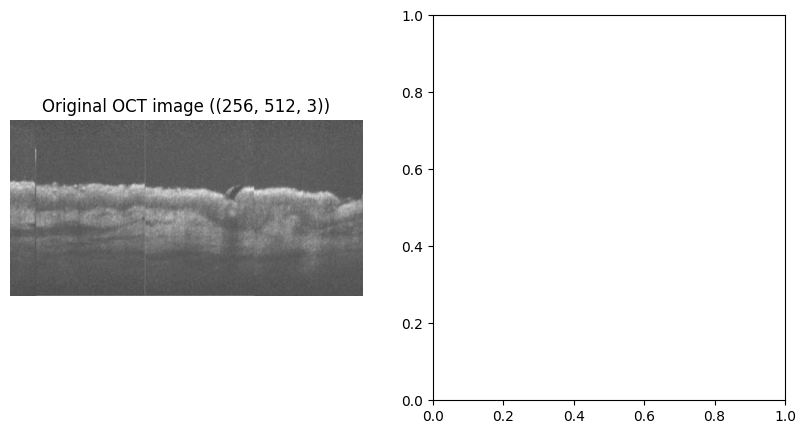

In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load OCT image
oct_image_orig = cv2.imread(oct_input_image_path)
oct_image_orig = cv2.cvtColor(oct_image_orig, cv2.COLOR_BGR2RGB)
oct_image = oct_image_orig.copy()
# Show Images to user
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
oct_image_orig_shape = oct_image.shape
axes[0].imshow(oct_image)
axes[0].axis("off")
axes[0].set_title(f"Original OCT image ({oct_image_orig_shape})")



In [41]:
#update the image to be 2mic/pix on the x axis, and 1mic/pix on the y axis.
new_image_width = int(oct_image.shape[1] * microns_per_pixel_x / MICRONS_PER_PIXEL_X_TARGET)
new_image_height = int(oct_image.shape[0] * microns_per_pixel_z / MICRONS_PER_PIXEL_Z_TARGET)

if new_image_width<VIRTUAL_HIST_WIDTH or VIRTUAL_HIST_HEIGHT<256:
  print(f"Image at target x/z rate is smaller than ({VIRTUAL_HIST_HEIGHT},{VIRTUAL_HIST_WIDTH}), and will be placed at top left corner.")
#warn about cropping
if new_image_width>VIRTUAL_HIST_WIDTH or new_image_height>VIRTUAL_HIST_HEIGHT:
  raise Exception(f"Image at target x/z rate is too large: ({new_image_height},{new_image_width}), please adjust so that it won't be larger than ({VIRTUAL_HIST_HEIGHT},{VIRTUAL_HIST_WIDTH}).")

In [42]:
%cd /content/OCT2Hist-UseModel

/content/OCT2Hist-UseModel


In [43]:
from utils.masking_utils import mask_image
preprocessed_img = mask_image(oct_image)

In [ ]:
#TODO: the main difference between this code's blacking out and the matlab is that here, there's not enough image height to jump -100/+500 rows. (inside "mask_image" function)
#qualitatively, the poster images skin part takes much greater percen from the height, around 90%, compared to our images, which take around 30%).

#the relevant matlab instructions were:
# (2) "Blackout" everything way above and way below the tissue-gel interface
# The idea is that anything that is much higher than the tissue-gel interface is not relevant because it is deep in the gel, and anything way below the interface is also not relevant because it is deep in the tissue and we don't get OCT signal that deep.

# The sub steps of this are:
# (a) We manually find the average pixel depth of the tissue-gel interface. This is not an accurate step, we basically use a mouse to click on the image where we think the average is. We call this depth Z
# (b) We black out anything above Z-100 pixels (in practice this is Z-100 microns)
# (c) We black out anything below Z+500 pixels. (in practice this is Z+500 microns)

#visualize user input to processed input

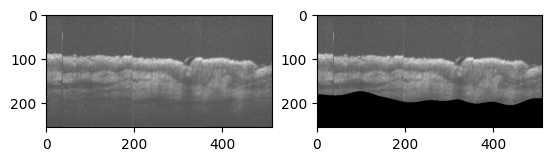

In [44]:
from utils.img_utils import showTwoImgs
#visualize
showTwoImgs(oct_image_orig, preprocessed_img)

In [45]:
target_rate_img = cv2.resize(img, (new_image_width, new_image_height), interpolation=cv2.INTER_AREA)
o2h_input = np.zeros((VIRTUAL_HIST_HEIGHT,VIRTUAL_HIST_WIDTH, 3),dtype=np.uint8)
o2h_input[:new_image_height, :new_image_width,:] = target_rate_img

#visualize oct2hist input

#visualize user input to o2h input

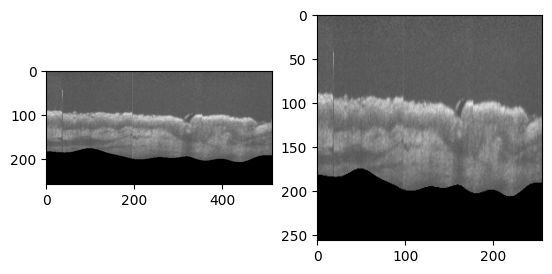

In [46]:
from utils.img_utils import showTwoImgs
#visualize
showTwoImgs(oct_image, o2h_input)

In [47]:
# Perform pre-process
oct_image_preprocessed = o2h_input

# Show image to user
oct_image_preprocessed_shape = oct_image_preprocessed.shape
axes[1].imshow(oct_image)
axes[1].axis("off")
axes[1].set_title(f"Preprocessed OCT image ({oct_image_preprocessed_shape})")
plt.show()

Format image the way that pix2pix code likes it

In [48]:
# Create a folder and place OCT image
!mkdir {base_folder}/dataset
!mkdir {base_folder}/dataset/test/

# Before writting image to file, check size
if oct_image_preprocessed.shape[:2] != (256, 256):
        raise ValueError("Image size must be 256x256 pixels to run model on.")

# Padd image and write it to the correct place
padded = np.zeros([256,512,3], np.uint8)
padded[:,:256,:] = oct_image_preprocessed[:,:,:]
cv2.imwrite(f"{base_folder}/dataset/test/im1.jpg", padded)

mkdir: cannot create directory ‘/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/dataset’: File exists
mkdir: cannot create directory ‘/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/dataset/test/’: File exists


True

# Run Model

In [49]:
!python {base_folder}/test.py --netG resnet_9blocks --dataroot "{base_folder}/dataset/"  --model pix2pix --name pix2pix --checkpoints_dir "{base_folder}/checkpoints" --results_dir "{base_folder}/results"

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/checkpoints	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/dataset/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False  

# Show results

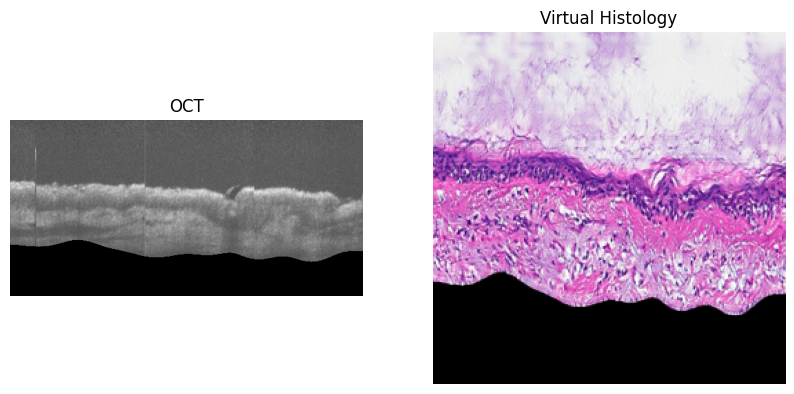

In [50]:
# Load the virtual histology image
histology_image = cv2.imread(f"{base_folder}/results/pix2pix/test_latest/images/im1_fake_B.png")
histology_image = cv2.cvtColor(histology_image, cv2.COLOR_BGR2RGB)

# present side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(oct_image)
axes[0].axis("off")
axes[0].set_title("OCT")
axes[1].imshow(histology_image)
axes[1].axis("off")
axes[1].set_title("Virtual Histology")
plt.show()


In [51]:
height,width = preprocessed_img.shape[:2]
histology_image_resized = cv2.resize(histology_image, [width,height] , interpolation=cv2.INTER_AREA)
print(histology_image_resized.shape)


(256, 512, 3)


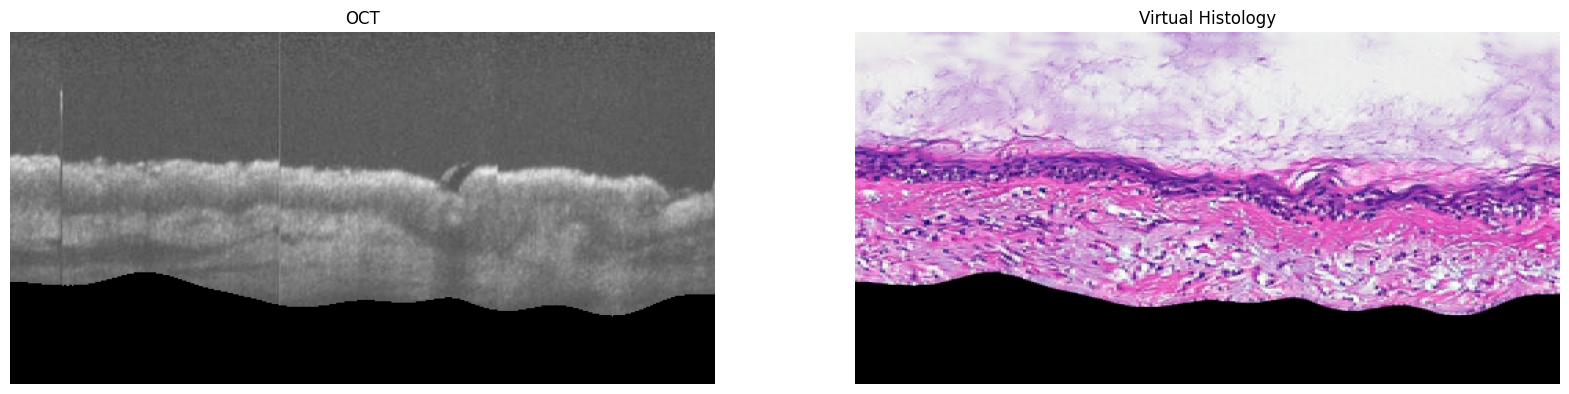

In [52]:
from utils.img_utils import showTwoImgs
#visualize

# present side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(preprocessed_img)
axes[0].axis("off")
axes[0].set_title("OCT")
axes[1].imshow(histology_image_resized)
axes[1].axis("off")
axes[1].set_title("Virtual Histology")
plt.show()